<a href="https://colab.research.google.com/github/pequitas33/Curso-RSG/blob/main/An%C3%A1lisis_WGCNA_RSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Redes de co-expresión génica con R** 💻





### *Sofía Zeballos, Lucas Inchausti*

# **Introducción al Taller** 🧬

En este taller exploraremos cómo construir y analizar redes de co-expresión génica utilizando el paquete `WGCNA` en R. Este tipo de análisis permite identificar grupos de genes (módulos/clusters) altamente correlacionados, lo que puede revelar patrones funcionales y relaciones biológicas relevantes.

También utilizaremos herramientas de enriquecimiento funcional para interpretar los módulos encontrados, y discutiremos qué otro tipo de análisis pueden realizarse a partir de la construcción de redes de co-expresión.

Para ello, utilizaremos datos de bulk RNA-seq del desarrollo del nemátodo _C. elegans_ obtenidos de Boeck et al., 2016 (https://genome.cshlp.org/content/26/10/1441.full.pdf)


## Pre-procesamiento de los datos

Partiremos de una matriz de conteos normalizados (TPM) para los 19.928 genes de C. elegans, y los distintos estadios del desarrollo:

* N2_4cell
* N2_0min
* N2_30min
* N2_60min
* N2_210min
* N2_240min
* N2_300min
* N2_330min
* N2_360min
* N2_390min
* N2_420min
* N2_450min
* N2_480min
* N2_510min
* N2_540min
* N2_570min
* N2_600min
* N2_630min
* N2_660min
* N2_690min
* L1
* L2
* L3
* DauerEntryDAF2
* DauerDAF2
* DauerExitDAF2
* L4
* YA

In [ ]:
# Instalación y carga de paquetes

if(!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("WGCNA") #
BiocManager::install("clusterProfiler") # Para analisis de enriquecimiento funcional
BiocManager::install("org.Ce.eg.db")  # Base de datos para C. elegans
BiocManager::install("enrichplot")    # Para visualización de resultados
BiocManager::install("biomaRt", quietly=TRUE, ask=FALSE, update=FALSE) #Se usa para buscar las descripciones de wormbase
if (!requireNamespace("Biostrings", quietly = TRUE)) {
  install.packages("Biostrings")
}
library(Biostrings)

library(biomaRt)
library(WGCNA)
library(clusterProfiler)
library(org.Ce.eg.db)
library(enrichplot)
library(dplyr)


#Seteamos una semilla
set.seed(123)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Installing package(s) 'BiocVersion', 'WGCNA'

also installing the dependencies ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘XVector’, ‘GenomeInfoDb’, ‘checkmate’, ‘plogr’, ‘png’, ‘Biostrings’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘colorspace’, ‘Formula’, ‘iterators’, ‘BiocGenerics’, ‘Biobase’, ‘IRanges’, ‘RSQLite’, ‘S4Vectors’, ‘KEGGREST’, ‘dynamicTreeCut’, ‘fastcluster’, ‘matrixStats’, ‘Hmisc’, ‘impute’, ‘foreach’, ‘doParallel’, ‘preprocessCore’, ‘GO.db’, ‘AnnotationDbi’


Old packages: 'dbplyr', 'googledrive', 'stringr'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Rep

In [ ]:
# Cargamos los datos de expresión génica.
dataset = read.table("Boeck_et_al_experiment_gene-count_normalized_TPM.csv", sep=",", header=T)

In [ ]:
head(dataset) # Visualizamos el dataset

,Gene,N2_4cell,N2_0min,N2_30min,N2_60min,N2_210min,N2_240min,N2_300min,N2_330min,N2_360min,⋯,N2_660min,N2_690min,L1,L2,L3,DauerDAF2,DauerEntryDAF2,DauerExitDAF2.2,L4,YA
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WBGene00007063,9.27163972,1.52582595,14.8186611,21.06031462,76.77136429,20.7561340,39.19503624,60.0876266,27.7845307,⋯,9.0176713,9.1814366,7.0067011,6.3278299,1.0948523,5.81975583,2.393189,6.4648123,4.16064680,1.0278017
2,WBGene00007064,8.17574581,47.12085739,39.3216007,56.62596262,67.57762574,33.7881860,69.10926048,128.0541319,66.2117139,⋯,33.0485664,80.0009487,14.4825911,27.9545047,7.5936496,56.78136948,38.370087,153.7985350,14.81717949,5.6197413
3,WBGene00007065,18.30832693,29.41507452,17.7555250,13.50213205,11.90703724,18.6275668,4.39236835,5.2527126,5.1144137,⋯,0.9382076,5.6980258,5.8385703,5.0762940,5.4173006,15.05384625,15.334193,36.8934359,12.94201182,12.1083241
4,WBGene00003525,0.26391857,0.11170694,0.0000000,0.00000000,0.00000000,0.6453572,0.18381819,0.6698393,0.2561099,⋯,40.3894880,33.9423562,0.6473829,33.8130501,3.5733902,0.04822545,3.904042,0.2241375,15.93422629,0.9971654
5,WBGene00007067,0.02952161,0.02340802,0.1298203,0.06809618,0.09358315,0.6257527,0.03774292,0.2115611,0.0000000,⋯,8.2158695,5.4821451,4.5062926,7.5492349,1.7457681,5.23110878,7.372290,9.4783236,0.98726895,1.1154456
6,WBGene00005532,0.05918033,0.50205010,0.4457885,0.87754894,1.05005726,0.4720907,0.33415811,0.1440950,0.3488500,⋯,0.1843175,0.2118928,0.2007897,0.1181166,0.1178029,1.11931409,1.392603,1.2406240,0.05566631,0.1347797


In [ ]:
# Hacemos un pulido al dataset
rownames(dataset) = dataset$Gene # Agregamos la columna Gene como nombres de las filas
dataset = dataset[,-1] # Eliminamos la columna Gene
dataset = t(dataset) # Trasponemos el dataframe para obtener uno en formato muestras (filas) x genes (columnas)
head(dataset[,1:5]) # Visualizamos el dataset pulido

,WBGene00007063,WBGene00007064,WBGene00007065,WBGene00003525,WBGene00007067
N2_4cell,9.271640,8.175746,18.30833,0.2639186,0.02952161
N2_0min,1.525826,47.120857,29.41507,0.1117069,0.02340802
N2_30min,14.818661,39.321601,17.75553,0.0000000,0.12982033
N2_60min,21.060315,56.625963,13.50213,0.0000000,0.06809618
N2_210min,76.771364,67.577626,11.90704,0.0000000,0.09358315
N2_240min,20.756134,33.788186,18.62757,0.6453572,0.62575270


In [ ]:
dataset = log2(1+dataset) # Logaritmizamos los datos normalizados (TPM) de expresión génica
head(dataset[,1:5]) # Visualizamos

,WBGene00007063,WBGene00007064,WBGene00007065,WBGene00003525,WBGene00007067
N2_4cell,3.360595,3.197825,4.271151,0.3379035,0.04197411
N2_0min,1.336755,5.588590,4.926715,0.1527765,0.03338145
N2_30min,3.983556,5.333481,4.229244,0.0000000,0.17609337
N2_60min,4.463381,5.848647,3.858193,0.0000000,0.09504156
N2_210min,6.281167,6.099666,3.690086,0.0000000,0.12906292
N2_240min,4.443350,5.120526,4.294809,0.7184008,0.70110782


In [ ]:
# Por cuestiones de capacidad de cómputo, conservaremos para el análisis los 10.000 genes con mayor varianza

# Calculamos la varianza de cada gen (columna)
var_genes <- apply(dataset, 2, var)

# Ordenamos los genes por varianza en orden descendente
ordered_genes <- order(var_genes, decreasing = TRUE)

# Seleccionamos los 10,000 genes con mayor varianza
top_genes <- ordered_genes[1:10000]

# Creamos un nuevo dataframe con esos genes
dataset_top_genes <- dataset[, top_genes]

# Renombramos las columnas para que reflejen que son los genes con mayor varianza
colnames(dataset_top_genes) <- colnames(dataset)[top_genes]

dataset <- dataset_top_genes

## Construcción de la red de co-expresión génica

In [ ]:
# Realizamos clustering jerárquico de las muestras, con el fin de identificar posibles muestras outlier que podrían ser eventualmente removidas
samplesTree <- hclust(d = dist(dataset), method = "average")

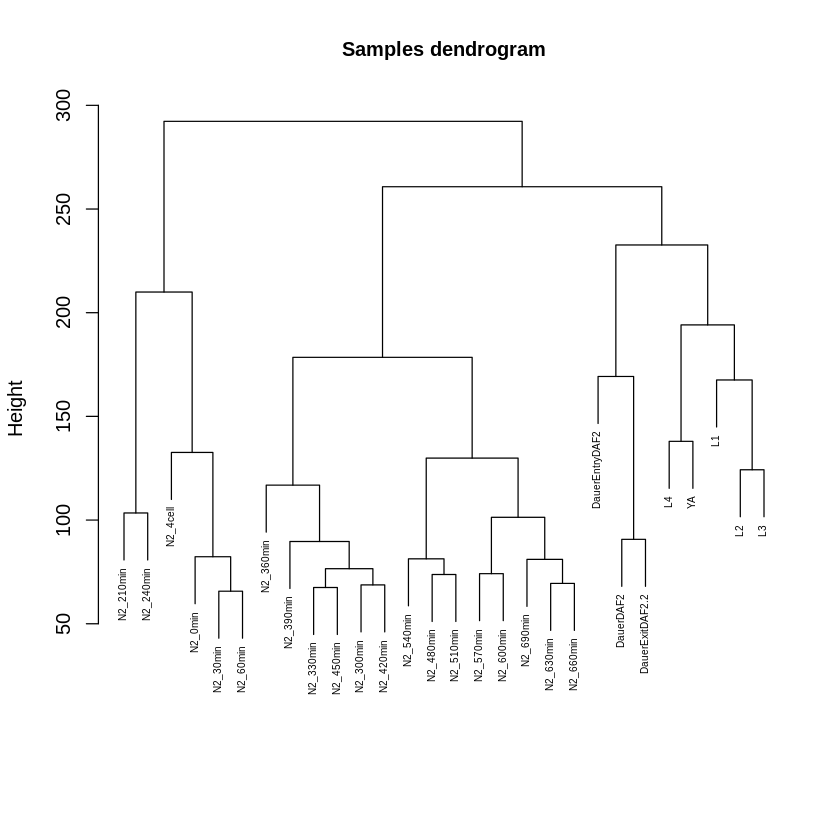

In [ ]:
plot(samplesTree, main = "Samples dendrogram", sub = "", xlab = "", cex.lab = 1, cex.axis = 1, cex.main = 1, cex = 0.5)

Para construir la red, los valores de correlación se transforman según un factor de corrección que realza las diferencias entre correlaciones fuertes y débiles, haciendo que los valores débiles se acerquen a cero, que permitirá generar un grafo de tipo scale-free.

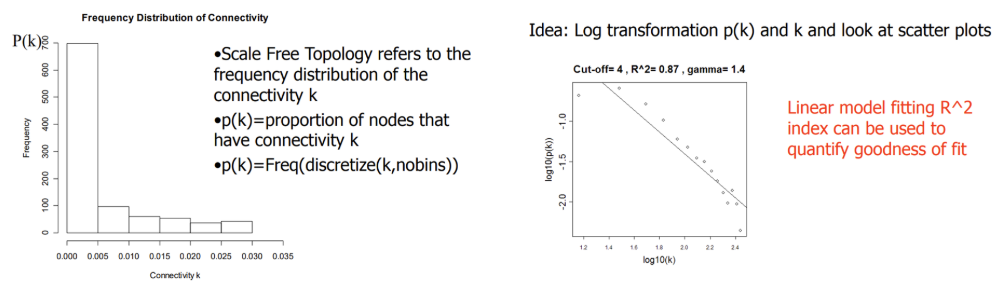

In [ ]:
# Determinamos el rango de valores para elegir el parámetro de soft thresholding óptimo
powers <- c(c(1:10), seq(from = 12, to = 30, by = 2))
powers

[1]  1  2  3  4  5  6  7  8  9 10 12 14 16 18 20 22 24 26 28 30

In [ ]:
# Determinamos el soft thresholding óptimo
sft <- pickSoftThreshold(dataset, powerVector = powers, verbose = 5)

pickSoftThreshold: will use block size 4473.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 4473 of 10000


Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   ..working on genes 4474 through 8946 of 10000
   ..working on genes 8947 through 10000 of 10000
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.5940  2.740          0.942  3920.0   4010.00   5420
2      2   0.2830  0.850          0.872  2100.0   2130.00   3530
3      3   0.0128  0.133          0.802  1290.0   1280.00   2520
4      4   0.0428 -0.227          0.820   856.0    832.00   1890
5      5   0.1830 -0.486          0.846   601.0    569.00   1460
6      6   0.2980 -0.640          0.886   439.0    406.00   1160
7      7   0.3950 -0.769          0.914   331.0    308.00    934
8      8   0.4640 -0.868          0.927   256.0    236.00    765
9      9   0.5230 -0.945          0.939   202.0    184.00    635
10    10   0.5580 -1.020          0.942   162.0    146.00    535
11    12   0.5940 -1.150          0.928   109.0     93.80    392
12    14   0.6280 -1.220          0.924    76.6     62.70    297
13    16   0.7100 -1.190          0.947    55.9     43.3

In [ ]:
sprintf("Optimal soft-power = %d", sft$powerEstimate)

[1] "Optimal soft-power = 24"

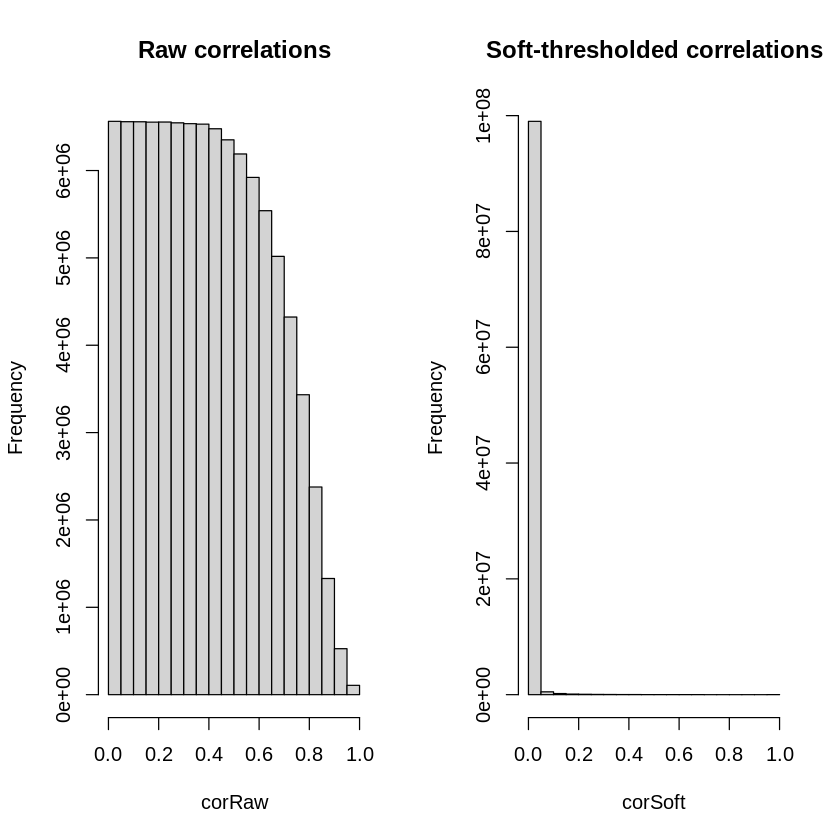

In [ ]:
# Visualizamos la diferencia de la distribución entre las correlaciones crudas y las correlaciones transformadas
corRaw = abs(cor(dataset))
corSoft = abs(corRaw**sft$powerEstimate)
par(mfrow=c(1,2))
hist(corRaw, main="Raw correlations")
hist(corSoft, main="Soft-thresholded correlations")

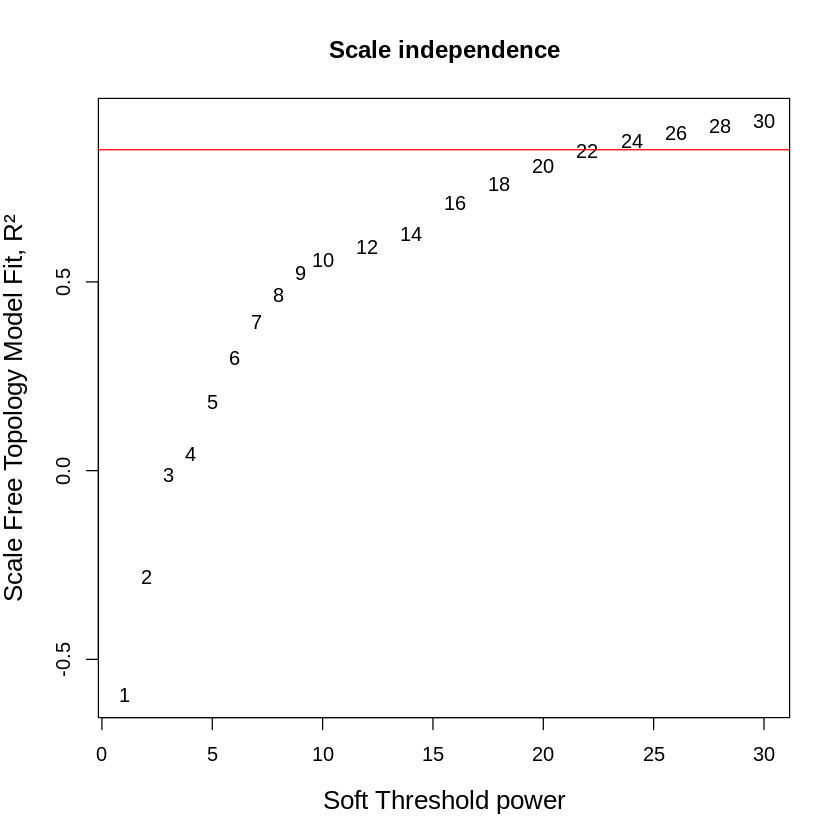

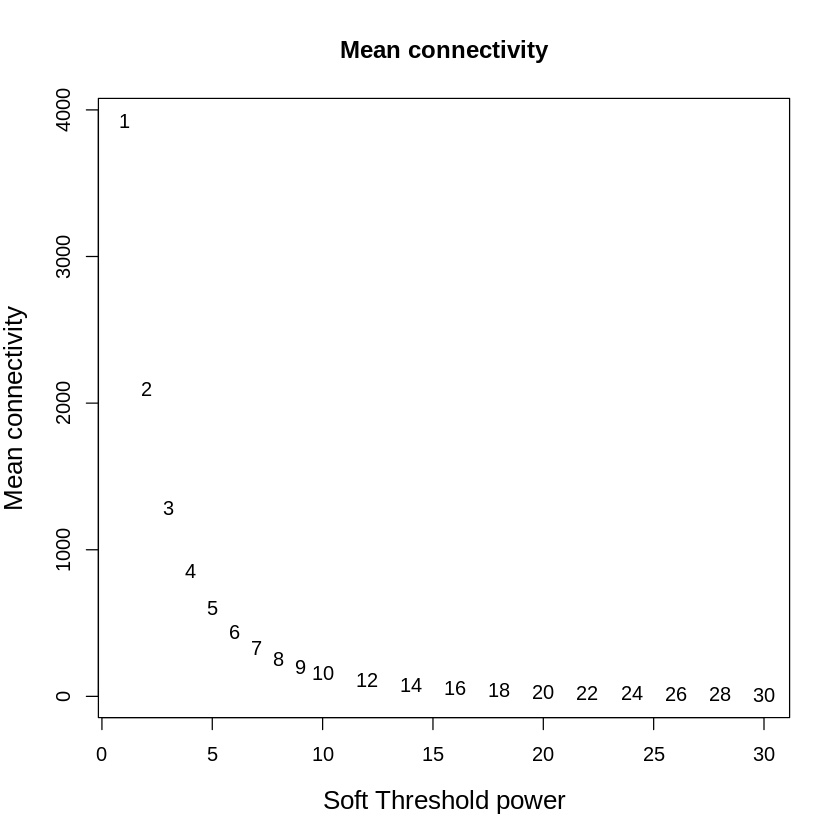

In [ ]:
# Visualizamos
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])* sft$fitIndices[,2],
     xlab = "Soft Threshold power", ylab = "Scale Free Topology Model Fit, R²",
     type = "n", main = "Scale independence", cex.lab = 1.3)
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])* sft$fitIndices[,2], labels = powers, cex = 1, col = "black")
abline(h = 0.85, col = "red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab = "Soft Threshold power", ylab = "Mean connectivity",
     type = "n", main = "Mean connectivity", cex.lab = 1.3)
text(sft$fitIndices[,1], sft$fitIndices[,5], labels = powers, cex = 1, col = "black")

In [ ]:
# Construimos la matriz de adyacencia
softPower = sft$powerEstimate
similarityMat <- adjacency(dataset, power = softPower)
head(similarityMat[, c(1:5)])

,WBGene00001075,WBGene00001076,WBGene00001858,WBGene00010234,WBGene00018297
WBGene00001075,1.000000e+00,6.289816e-01,1.822392e-01,3.249921e-03,1.289815e-17
WBGene00001076,6.289816e-01,1.000000e+00,1.011536e-01,9.998241e-03,9.161529e-19
WBGene00001858,1.822392e-01,1.011536e-01,1.000000e+00,9.387655e-06,4.301268e-11
WBGene00010234,3.249921e-03,9.998241e-03,9.387655e-06,1.000000e+00,6.391220e-15
WBGene00018297,1.289815e-17,9.161529e-19,4.301268e-11,6.391220e-15,1.000000e+00
WBGene00009983,3.991277e-13,4.955110e-14,1.083141e-08,5.702394e-19,6.698549e-01


In [ ]:
# Construimos la Topological Overlapping Matrix (similaridad)
TOM <- TOMsimilarity(similarityMat)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [ ]:
colnames(TOM) <- colnames(similarityMat)
rownames(TOM) <- rownames(similarityMat)
head(TOM[, c(1:5)])

,WBGene00001075,WBGene00001076,WBGene00001858,WBGene00010234,WBGene00018297
WBGene00001075,1.000000e+00,1.137739e-01,8.698001e-02,1.143215e-02,3.482072e-07
WBGene00001076,1.137739e-01,1.000000e+00,5.598072e-02,2.483703e-02,1.322164e-07
WBGene00001858,8.698001e-02,5.598072e-02,1.000000e+00,4.224622e-04,1.544980e-05
WBGene00010234,1.143215e-02,2.483703e-02,4.224622e-04,1.000000e+00,4.183528e-07
WBGene00018297,3.482072e-07,1.322164e-07,1.544980e-05,4.183528e-07,1.000000e+00
WBGene00009983,2.484868e-06,1.015942e-06,7.203764e-05,7.440232e-08,1.833683e-01


In [ ]:
# Construimos la matriz dissTOM = 1 - TOM (distancia)
dissTOM <- 1 - TOM
head(dissTOM[, c(1:5)])

,WBGene00001075,WBGene00001076,WBGene00001858,WBGene00010234,WBGene00018297
WBGene00001075,0.0000000,0.8862261,0.9130200,0.9885679,0.9999997
WBGene00001076,0.8862261,0.0000000,0.9440193,0.9751630,0.9999999
WBGene00001858,0.9130200,0.9440193,0.0000000,0.9995775,0.9999846
WBGene00010234,0.9885679,0.9751630,0.9995775,0.0000000,0.9999996
WBGene00018297,0.9999997,0.9999999,0.9999846,0.9999996,0.0000000
WBGene00009983,0.9999975,0.9999990,0.9999280,0.9999999,0.8166317


A partir de la matriz de distancia, podemos agrupar los genes con patrones de expresión más similares en clusters. Ya hemos utilizado la función hclust arriba para agrupar las muestras. Ahora la usaremos en nuestra Matriz de Disimilaridad para agrupar los genes en clusters. Para obtener más detalles sobre esta función, puedes llamar a help(hclust).

Aquí, la Matriz de Disimilaridad y el dendrograma se utilizarán para convertir los clusters en colores. Luego, trazaremos el dendrograma con los colores a continuación.

Algunos módulos son muy similares, por lo que se pueden fusionar en un único cluster según un umbral de corte.

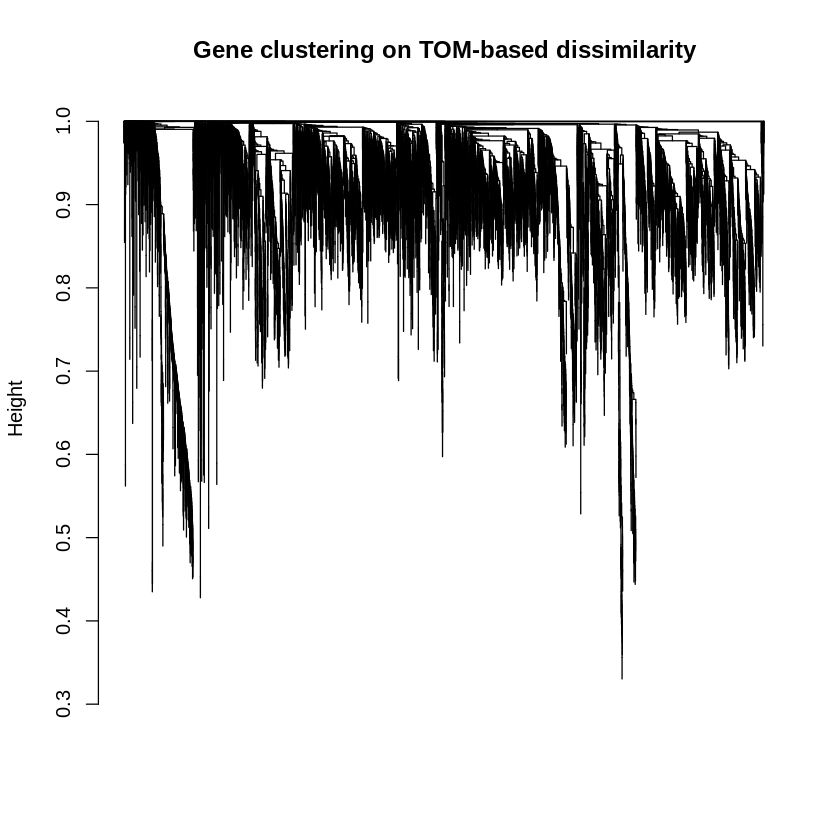

In [ ]:
# Identificamos los módulos de genes co-expresados usando clustering jerárquico
geneTree <- hclust(as.dist(dissTOM), method = "average")
plot(geneTree, xlab = "", sub = "", main = "Gene clustering on TOM-based dissimilarity", labels = FALSE, hang = 0.04)

In [ ]:
# Identificamos y etiquetamos los módulos de genes co-expresados
minModuleSize <- 50 # Tamaño mínimo de cada módulo
dynamicMods <- cutreeDynamic(dendro = geneTree,
                             distM = dissTOM,
                             deepSplit = 2,
                             pamRespectsDendro = FALSE,
                             minClusterSize = minModuleSize)

 ..cutHeight not given, setting it to 0.997  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [ ]:
table(dynamicMods) # Cantidad de módulos y cantidad de genes contenidos en cada módulo

dynamicMods
  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19 
722 646 644 550 454 444 414 402 344 344 285 260 245 235 223 204 202 200 197 196 
 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39 
192 186 181 171 170 169 168 161 161 145 142 138 131 124 110 110 108  89  75  58 

In [ ]:
dynamicColors <- labels2colors(dynamicMods) # Cambiamos las etiquetas de números a colores
table(dynamicColors)

dynamicColors
         black           blue          brown           cyan      darkgreen 
           402            644            550            223            181 
      darkgrey    darkmagenta darkolivegreen     darkorange        darkred 
           170            110            124            168            186 
 darkturquoise          green    greenyellow           grey         grey60 
           171            444            260            722            200 
     lightcyan     lightgreen    lightyellow        magenta   midnightblue 
           202            197            196            344            204 
        orange     orangered4  paleturquoise           pink          plum1 
           169             58            138            344             75 
        purple            red      royalblue    saddlebrown         salmon 
           285            414            192            145            235 
       sienna3        skyblue       skyblue3      steelblue            tan

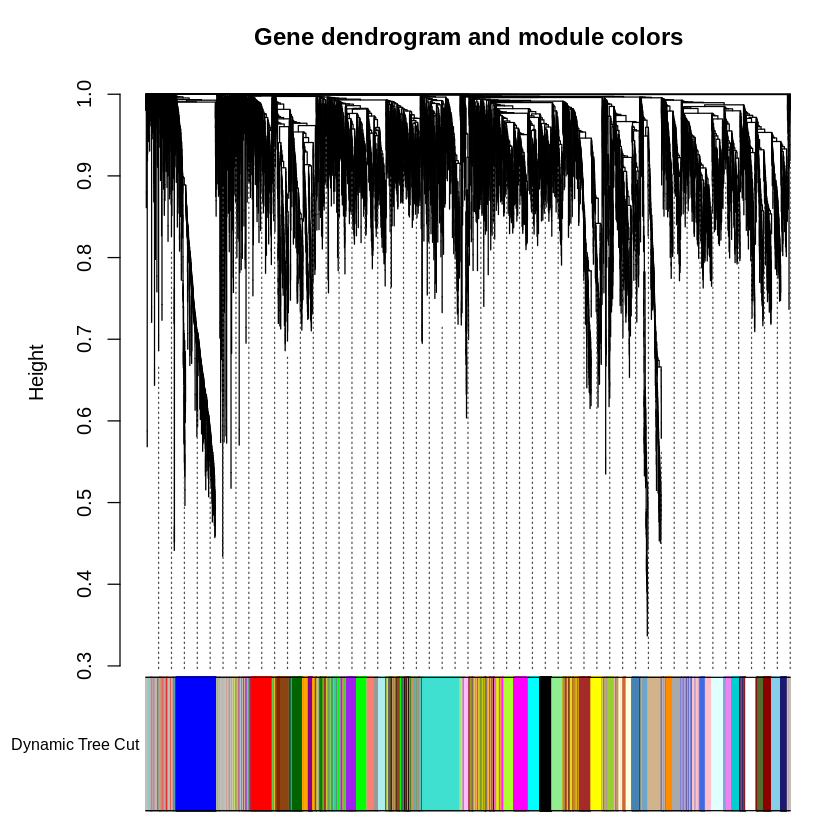

In [ ]:
# Visualizamos dendrograma con colores segun pertenencia a cada módulo
plotDendroAndColors(dendro = geneTree, colors = dynamicColors, groupLabels = "Dynamic Tree Cut",
        dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, guideHang = 0.05,
        main = "Gene dendrogram and module colors")

In [ ]:
# Calculamos los Module Eigengenes
MEList <- moduleEigengenes(dataset, colors = dynamicColors)
MEs <- MEList$eigengenes
head(MEs)

,MEblack,MEblue,MEbrown,MEcyan,MEdarkgreen,MEdarkgrey,MEdarkmagenta,MEdarkolivegreen,MEdarkorange,MEdarkred,⋯,MEsienna3,MEskyblue,MEskyblue3,MEsteelblue,MEtan,MEturquoise,MEviolet,MEwhite,MEyellow,MEyellowgreen
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
N2_4cell,-0.3201990,0.022996395,0.3359864,-0.2660436,-0.1863275,-0.12436449,-0.1334407,-0.08076100,0.01973939,-0.11417627,⋯,-0.13250509,-0.12013250,-0.042072289,-0.1316435,-0.07026368,0.4687557,-0.1684244,-0.06829391,0.1745015,-0.08618123
N2_0min,-0.3584575,-0.053130273,0.4620640,-0.2939503,-0.1973441,-0.03801974,-0.1562218,-0.10684449,0.10087695,-0.14313102,⋯,-0.15322692,-0.15693610,-0.076893130,-0.1894770,-0.09274650,0.4630255,-0.2224554,-0.14931208,0.3087775,-0.13905590
N2_30min,-0.3379498,-0.060158185,0.4786159,-0.3095731,-0.2064392,0.06716907,-0.1586327,-0.11984055,0.16497114,-0.13709115,⋯,-0.14464580,-0.15779188,-0.074907825,-0.1931078,-0.09431760,0.4001410,-0.2219474,-0.15049027,0.3493141,-0.13261252
N2_60min,-0.3241282,-0.056720942,0.4481751,-0.3052028,-0.2101337,0.13234315,-0.1570452,-0.12011144,0.18338059,-0.12810347,⋯,-0.13629815,-0.15238906,-0.073257188,-0.1833135,-0.08784827,0.3067344,-0.2117766,-0.14825212,0.3624189,-0.13149834
N2_210min,-0.2773158,-0.031564897,0.1442258,-0.2547383,-0.1942598,0.34634926,-0.1455101,-0.07032270,0.50437320,-0.08835070,⋯,-0.10476342,-0.09738333,-0.051612055,-0.1579502,-0.05110970,-0.0742197,-0.1790008,-0.10829980,0.4333564,-0.09831793
N2_240min,-0.2797429,0.007526624,0.1394479,-0.2192888,-0.1614790,0.27493564,-0.1102080,-0.03731083,0.45754513,-0.05835394,⋯,-0.06692776,-0.07511826,-0.006150378,-0.1243206,-0.03281020,-0.0936758,-0.1351097,-0.07312103,0.4068575,-0.07408644


In [ ]:
MEs <- orderMEs(MEs)
head(MEs)

,MEplum1,MEdarkgrey,MEdarkorange,MEturquoise,MEbrown,MEyellow,MEpurple,MEred,MEpaleturquoise,MEgreen,⋯,MEdarkolivegreen,MEtan,MEdarkred,MEwhite,MEmidnightblue,MEviolet,MEpink,MEroyalblue,MEskyblue,MEgrey
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
N2_4cell,0.44162203,-0.12436449,0.01973939,0.4687557,0.3359864,0.1745015,-0.269619303,-0.2592594,-0.1807861,-0.36040987,⋯,-0.08076100,-0.07026368,-0.11417627,-0.06829391,-0.1806950,-0.1684244,-0.1985488,-0.1535128,-0.12013250,-0.13667975
N2_0min,0.08608280,-0.03801974,0.10087695,0.4630255,0.4620640,0.3087775,-0.312390496,-0.2793921,-0.2348372,-0.40733675,⋯,-0.10684449,-0.09274650,-0.14313102,-0.14931208,-0.2165618,-0.2224554,-0.2169332,-0.1717833,-0.15693610,-0.02766381
N2_30min,0.08559684,0.06716907,0.16497114,0.4001410,0.4786159,0.3493141,-0.267688151,-0.1941129,-0.2268392,-0.35984423,⋯,-0.11984055,-0.09431760,-0.13709115,-0.15049027,-0.2234567,-0.2219474,-0.2242053,-0.1808583,-0.15779188,-0.07661050
N2_60min,0.19723281,0.13234315,0.18338059,0.3067344,0.4481751,0.3624189,-0.217413591,-0.1266539,-0.2326186,-0.32239630,⋯,-0.12011144,-0.08784827,-0.12810347,-0.14825212,-0.2136901,-0.2117766,-0.2236911,-0.1819782,-0.15238906,-0.05616030
N2_210min,0.49908860,0.34634926,0.50437320,-0.0742197,0.1442258,0.4333564,0.082125547,0.3002280,-0.1463251,-0.05428919,⋯,-0.07032270,-0.05110970,-0.08835070,-0.10829980,-0.1601949,-0.1790008,-0.2064411,-0.1713027,-0.09738333,0.48760327
N2_240min,0.24586612,0.27493564,0.45754513,-0.0936758,0.1394479,0.4068575,0.001138446,0.2484352,-0.1376815,-0.11913594,⋯,-0.03731083,-0.03281020,-0.05835394,-0.07312103,-0.1365632,-0.1351097,-0.1472057,-0.1336666,-0.07511826,0.63114253


In [ ]:
MEDiss <- 1 - cor(MEs)
head(MEDiss)

,MEplum1,MEdarkgrey,MEdarkorange,MEturquoise,MEbrown,MEyellow,MEpurple,MEred,MEpaleturquoise,MEgreen,⋯,MEdarkolivegreen,MEtan,MEdarkred,MEwhite,MEmidnightblue,MEviolet,MEpink,MEroyalblue,MEskyblue,MEgrey
MEplum1,2.220446e-16,0.3739766,0.1815417,0.6545056,0.4047024,0.2046271,0.9905613,0.6820359,1.2927688,1.3317430,⋯,1.424748,1.318422,1.472197,1.469720,1.678723,1.699699,1.768773,1.691382,1.571608,0.7374164
MEdarkgrey,3.739766e-01,0.0000000,0.1155818,1.1356420,0.7667427,0.4177258,0.3572918,0.1416544,0.7031366,0.6923133,⋯,1.706680,1.521726,1.783988,1.812209,1.857797,1.849263,1.751840,1.804932,1.780688,0.9707242
MEdarkorange,1.815417e-01,0.1155818,0.0000000,0.8794949,0.4745881,0.1383289,0.7422507,0.3899450,1.1072720,1.1120671,⋯,1.544207,1.407172,1.620489,1.651227,1.803639,1.818038,1.800742,1.769494,1.671964,0.6429511
MEturquoise,6.545056e-01,1.1356420,0.8794949,0.0000000,0.1603662,0.4720163,1.6325737,1.5728448,1.4883981,1.8105726,⋯,1.218278,1.213959,1.230701,1.184101,1.325518,1.291098,1.418791,1.335116,1.308317,1.1798638
MEbrown,4.047024e-01,0.7667427,0.4745881,0.1603662,0.0000000,0.1368820,1.5122092,1.2825429,1.5294722,1.7937591,⋯,1.304057,1.248724,1.364365,1.372237,1.567498,1.562857,1.596561,1.492868,1.411197,0.9163897
MEyellow,2.046271e-01,0.4177258,0.1383289,0.4720163,0.1368820,0.0000000,1.2095779,0.8537973,1.4235119,1.5626434,⋯,1.399206,1.310386,1.471914,1.497025,1.696629,1.705703,1.726783,1.640970,1.528840,0.6184284


In [ ]:
METree <- hclust(as.dist(MEDiss))

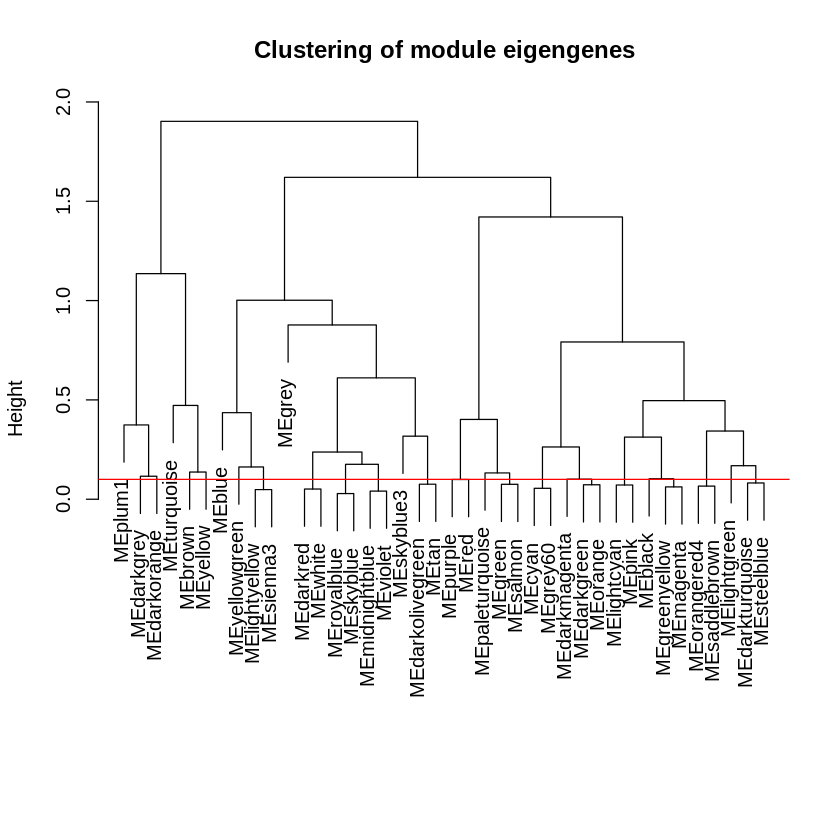

In [ ]:
MEDissCut <- 0.1
plot(METree, main = "Clustering of module eigengenes", xlab = "", sub = "")
abline(h = MEDissCut, col = "red")

 mergeCloseModules: Merging modules whose distance is less than 0.1
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 40 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 25 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 23 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 23 module eigengenes in given set.


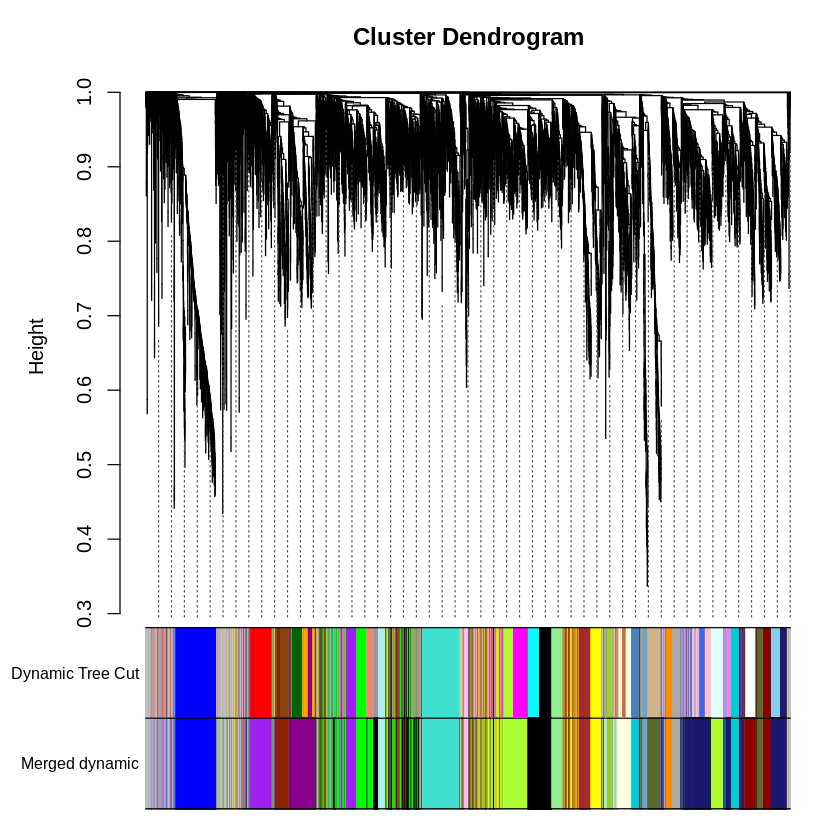

In [ ]:
# Combinamos clusters cuyos Module Eigengenes estén altamente correlacionados
merge <- mergeCloseModules(dataset, dynamicColors, cutHeight = MEDissCut, verbose = 3)
mergedColors <- merge$colors
mergedMEs <- merge$newMEs
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
        c("Dynamic Tree Cut", "Merged dynamic"),
        dendroLabels = FALSE, hang = 0.03,
        addGuide = TRUE, guideHang = 0.05)

In [ ]:
moduleColors <- mergedColors
colorOrder <- c("grey", standardColors(50))
moduleLabels <- match(moduleColors, colorOrder) - 1
MEs <- mergedMEs

In [ ]:
moduleColors = mergedColors
names(moduleColors) = colnames(dataset)
head(moduleColors)

WBGene00001075 WBGene00001076 WBGene00001858 WBGene00010234 WBGene00018297 
      "purple"       "purple"       "purple"     "darkgrey"  "darkmagenta" 
WBGene00009983 
 "darkmagenta"

In [ ]:
# Convertir el diccionario a un DataFrame
df_moduleColors <- data.frame(Gene = names(moduleColors),
                              ModuleColor = unname(moduleColors))

In [ ]:
df_moduleColors

Gene,ModuleColor
<chr>,<chr>
WBGene00001075,purple
WBGene00001076,purple
WBGene00001858,purple
WBGene00010234,darkgrey
WBGene00018297,darkmagenta
WBGene00009983,darkmagenta
WBGene00000301,darkgrey
WBGene00000717,darkturquoise
WBGene00001920,plum1


In [ ]:
length(unique(df_moduleColors$ModuleColor))

[1] 23

In [ ]:
table(moduleColors)

moduleColors
         black           blue          brown       darkgrey    darkmagenta 
           825            644            550            170            460 
darkolivegreen     darkorange        darkred  darkturquoise          green 
           369            168            347            313            679 
   greenyellow           grey     lightgreen    lightyellow   midnightblue 
           806            722            197            306           1032 
    orangered4  paleturquoise          plum1         purple       skyblue3 
           203            138             75            699             89 
     turquoise         yellow    yellowgreen 
           646            454            108 

In [ ]:
# Extraemos los genes pertenecientes a cada módulo

# Obtenemos los nombres de los módulos
unique_colors <- unique(df_moduleColors$ModuleColor)

# Creamos una lista para almacenar los genes por color
genes_by_color <- list()

# Iteramos sobre cada módulo
for (color in unique_colors) {
  # Filtrar los genes para el color actual
  genes <- df_moduleColors[df_moduleColors$ModuleColor == color, ]
  # Guardar los genes en la lista usando el nombre del color como clave
  genes_by_color[[color]] <- genes$Gene
}

# Vemos la lista resultante
print(genes_by_color)


$purple
  [1] "WBGene00001075" "WBGene00001076" "WBGene00001858" "WBGene00019514"
  [5] "WBGene00001828" "WBGene00000469" "WBGene00008563" "WBGene00001108"
  [9] "WBGene00007271" "WBGene00011383" "WBGene00001210" "WBGene00012239"
 [13] "WBGene00002051" "WBGene00002085" "WBGene00011175" "WBGene00009653"
 [17] "WBGene00016422" "WBGene00012186" "WBGene00013145" "WBGene00006366"
 [21] "WBGene00021525" "WBGene00021513" "WBGene00017562" "WBGene00021279"
 [25] "WBGene00022441" "WBGene00008263" "WBGene00008779" "WBGene00006956"
 [29] "WBGene00018547" "WBGene00009926" "WBGene00019426" "WBGene00017143"
 [33] "WBGene00001072" "WBGene00015063" "WBGene00007479" "WBGene00000695"
 [37] "WBGene00008102" "WBGene00021031" "WBGene00019282" "WBGene00002248"
 [41] "WBGene00019751" "WBGene00001123" "WBGene00009029" "WBGene00020379"
 [45] "WBGene00011838" "WBGene00001960" "WBGene00044417" "WBGene00020380"
 [49] "WBGene00008156" "WBGene00010893" "WBGene00008760" "WBGene00016553"
 [53] "WBGene00017296" "WBGene

In [ ]:
# Calculamos Module Memberhsip (correlación con module eigengene)
geneModuleMembership = as.data.frame(cor(dataset, MEs, use = "p"))
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))

# Renombramos columna
colnames(geneModuleMembership) = paste("MM", names(MEs), sep="")
colnames(MMPvalue) = paste("p.MM", names(MEs), sep="")

# Nos quedamos con los genes que tengan un MM > 0.8 en cada módulo
significant_genes_by_color <- list()

for (color in unique(moduleColors)) {
  moduleGenes = (moduleColors == color)
  moduleMEs = MEs[, paste("ME", color, sep="")]
  # Calculamos MM para los genes del modulo evaluado
  MM = as.numeric(cor(dataset[, moduleGenes], moduleMEs, use = "p"))

  # Creamos dataframe para el modulo evaluado con los genes y sus MM
  module_mm <- data.frame(Gene = colnames(dataset[, moduleGenes]), ModuleMembership = MM)

  # Filtramos por MM > 0.8
  significant_genes <- module_mm$Gene[abs(module_mm$ModuleMembership) > 0.8]

  # Guardamos los significativos en una lista
  significant_genes_by_color[[color]] <- significant_genes
}

print(significant_genes_by_color)

$purple
  [1] "WBGene00001075" "WBGene00001076" "WBGene00001858" "WBGene00019514"
  [5] "WBGene00001828" "WBGene00000469" "WBGene00008563" "WBGene00001108"
  [9] "WBGene00007271" "WBGene00011383" "WBGene00001210" "WBGene00012239"
 [13] "WBGene00002051" "WBGene00002085" "WBGene00011175" "WBGene00009653"
 [17] "WBGene00016422" "WBGene00012186" "WBGene00013145" "WBGene00006366"
 [21] "WBGene00021525" "WBGene00021513" "WBGene00017562" "WBGene00021279"
 [25] "WBGene00008263" "WBGene00008779" "WBGene00006956" "WBGene00018547"
 [29] "WBGene00009926" "WBGene00019426" "WBGene00001072" "WBGene00015063"
 [33] "WBGene00007479" "WBGene00000695" "WBGene00008102" "WBGene00021031"
 [37] "WBGene00019282" "WBGene00002248" "WBGene00019751" "WBGene00001123"
 [41] "WBGene00009029" "WBGene00020379" "WBGene00011838" "WBGene00001960"
 [45] "WBGene00044417" "WBGene00020380" "WBGene00008156" "WBGene00010893"
 [49] "WBGene00008760" "WBGene00016553" "WBGene00017296" "WBGene00012420"
 [53] "WBGene00001432" "WBGene

In [ ]:
# Comparamos la cantidad de genes antes y despues del filtrado por MM
original_counts = table(moduleColors)
filtered_counts = sapply(significant_genes_by_color, length)


comparison_df <- data.frame(
  Module = names(original_counts),
  Original_Count = as.numeric(original_counts),
  Filtered_Count = as.numeric(filtered_counts[names(original_counts)])
)


comparison_df$Filtered_Count[is.na(comparison_df$Filtered_Count)] <- 0

print(comparison_df)

           Module Original_Count Filtered_Count
1           black            825            681
2            blue            644            517
3           brown            550            442
4        darkgrey            170            145
5     darkmagenta            460            406
6  darkolivegreen            369            301
7      darkorange            168            135
8         darkred            347            315
9   darkturquoise            313            283
10          green            679            535
11    greenyellow            806            703
12           grey            722             45
13     lightgreen            197            178
14    lightyellow            306            257
15   midnightblue           1032            844
16     orangered4            203            194
17  paleturquoise            138            120
18          plum1             75             66
19         purple            699            421
20       skyblue3             89        

Visualicemos gráficamente uno de los módulos:


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:clusterProfiler’:

    simplify


The following object is masked from ‘package:Biostrings’:

    union


The following object is masked from ‘package:XVector’:

    path


The following object is masked from ‘package:IRanges’:

    union


The following object is masked from ‘package:S4Vectors’:

    union


The following objects are masked from ‘package:BiocGenerics’:

    normalize, path, union


The following objects are masked from ‘package:generics’:

    components, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




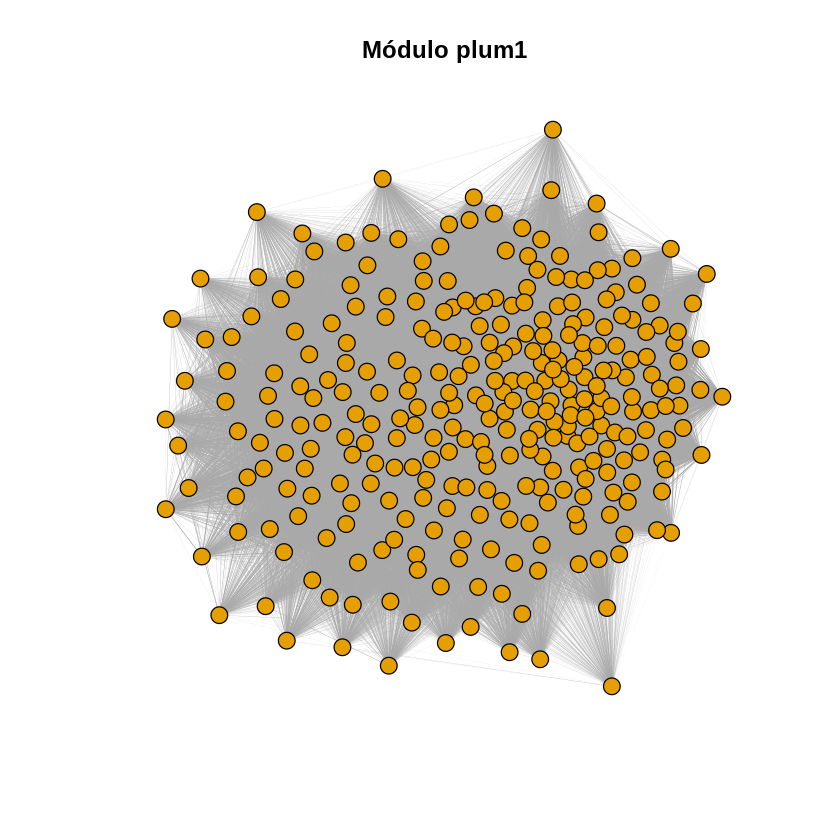

In [ ]:
# Para visualizar un módulo

# (en este caso el más chiquito que es plum1)
library(igraph)

# Genes del módulo
genes_plum1 <- significant_genes_by_color$darkolivegreen   # módulo de 75 genes

# Submatriz de la TOM solo con estos genes
TOMsub <- TOM[genes_plum1, genes_plum1]

# Grafo completo: todas las aristas, sin filtrar
g <- graph_from_adjacency_matrix(TOMsub,
                                 mode = "undirected",
                                 weighted = TRUE,
                                 diag = FALSE)

# Plot básico (con layout de Fruchterman-Reingold)
plot(g,
     vertex.size = 6,
     vertex.label = NA,   # quita etiquetas si se amontonan
     edge.width = E(g)$weight * 5,  # escala grosor según peso TOM
     main = "Módulo plum1",
     layout = layout_with_fr(g))

## Análisis de correlación Módulo-Estadio
Correlacionaremos los Module Eigengenes con las  etapas de desarrollo de *C. elegans*, que nos permitirá identificar módulos que podrían estar regulando procesos biológicos específicos en cada etapa del desarrollo.

In [ ]:
# Cargamos la matriz que asocia muestras a estadios del desarrollo embrionario
traits = read.csv('traits.csv', sep = ',', row.names = 1)

In [ ]:
# Calculamos la correlación entre MEs y estadios
nSamples = nrow((dataset))
moduleTraitCor = cor(MEs, traits, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);


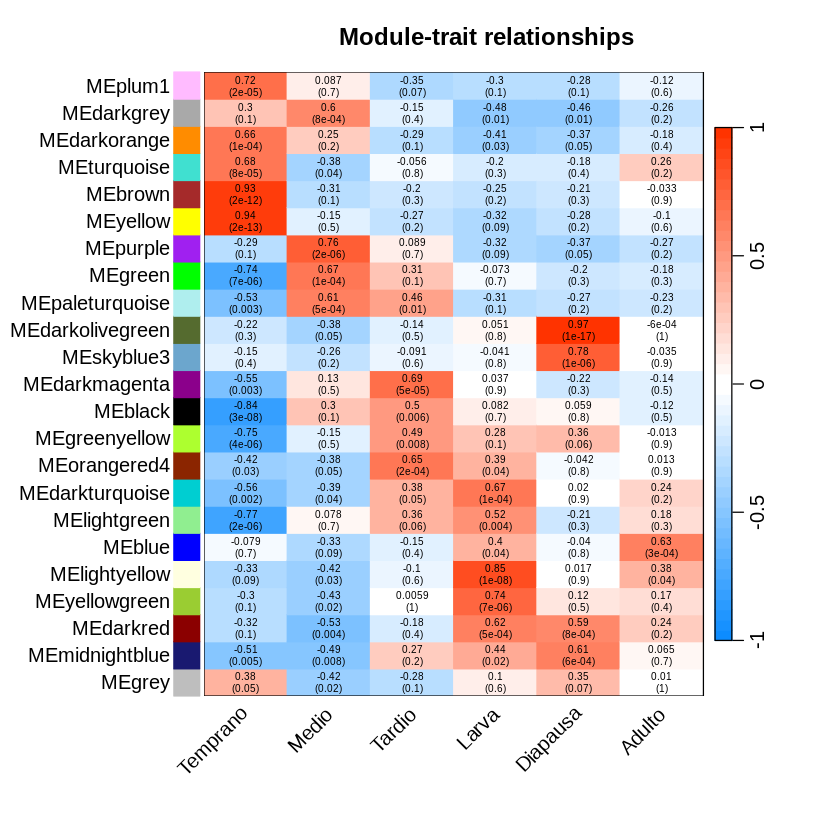

In [ ]:
# Heatmap Módulos-Estadios
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",
                   signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3));

labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = colnames(moduleTraitCor),
               yLabels = colnames(MEs),
               ySymbols = colnames(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))


## Análisis de enriquecimiento funcional de módulos de interés

Como discutimos en la parte teórica, el análisis de enriquecimiento de términos GO busca determinar si ciertos términos están representados en una proporción mayor a la esperada por azar dentro de un conjunto de genes (por ejemplo, un módulo de coexpresión). Para ello se compara la proporción de genes anotados con cada término GO en tu módulo frente a la proporción en todo el universo de genes analizados.

La herramienta estadística utilizada es el test hipergeométrico, que calcula la probabilidad de observar al menos k genes con ese término en tu conjunto, dado el número total de genes anotados en el universo. Un p-valor bajo indica que la representación del término es significativamente mayor de lo esperado, sugiriendo enriquecimiento funcional.

Veamos un ejemplo teórico de esto:

In [ ]:
# En nuestro ejemplo:
N <- 10000   # tamaño del universo (genes medibles)
K <- 200     # genes en el universo anotados con el GO term (p.ej. "ribosome")
n <- 100     # tamaño del módulo (gene set)
k <- 10      # genes en el módulo anotados con el GO term (p.ej. "ribosome")

# Calculamos proporciones
prop_universe <- ifelse(N > 0, K / N, NA)    # proporción en el universo (K/N)
prop_module   <- ifelse(n > 0, k / n, NA)    # proporción en el módulo (k/n)

# Valor esperado bajo el modelo nulo
expected_in_module <- n * prop_universe      # cuánto esperaríamos ver en el módulo por azar

# Calculamos fold enrichment
# Usamos (k/n) / (K/N). Si expected_in_module = 0 evitamos división por cero.
fold_enrichment <- NA
log2_fold <- NA
if (!is.na(prop_universe) && prop_universe > 0 && !is.na(prop_module)) {
  fold_enrichment <- prop_module / prop_universe
  log2_fold <- ifelse(fold_enrichment > 0, log2(fold_enrichment), NA)
} else if (!is.na(expected_in_module) && expected_in_module > 0) {
  fold_enrichment <- k / expected_in_module
  log2_fold <- ifelse(fold_enrichment > 0, log2(fold_enrichment), NA)
}

# Calculamos p-valor con un test hipergeométrico
p_hyper <- phyper(q = k - 1, m = K, n = N - K, k = n, lower.tail = FALSE)

# --- Salida ---
cat("=== Enriquecimiento GO (ejemplo) ===\n")
cat(sprintf("Universo: N = %d genes\n", N))
cat(sprintf("GO-term en universo: K = %d genes -> prop_universe = %.4f (%.2f%%)\n",
            K, prop_universe, 100 * prop_universe))
cat(sprintf("Módulo: n = %d genes\n", n))
cat(sprintf("GO-term en módulo: k = %d genes -> prop_module = %.4f (%.2f%%)\n\n",
            k, prop_module, 100 * prop_module))

cat(sprintf("Esperado en el módulo por azar = n * (K/N) = %.3f genes\n", expected_in_module))
cat(sprintf("Fold-enrichment = (k/n) / (K/N) = %.3f\n", fold_enrichment))
cat(sprintf("Log2 fold-enrichment = %.3f\n\n", log2_fold))

cat(sprintf("P-valor (hipergeométrico, P(X >= %d)) = %.4g\n", k, p_hyper))


=== Enriquecimiento GO (ejemplo) ===
Universo: N = 10000 genes
GO-term en universo: K = 200 genes -> prop_universe = 0.0200 (2.00%)
Módulo: n = 100 genes
GO-term en módulo: k = 10 genes -> prop_module = 0.1000 (10.00%)

Esperado en el módulo por azar = n * (K/N) = 2.000 genes
Fold-enrichment = (k/n) / (K/N) = 5.000
Log2 fold-enrichment = 2.322

P-valor (hipergeométrico, P(X >= 10)) = 2.962e-05


En nuestro caso, habiendo obtenido módulos cuya expresión está aumentada (o disminuída) en determinadas etapas del desarrollo de *C. elegans*, resulta interesante realizar un análisis de enriquecimiento funcional de términos GO para determinar qué procesos biológicos se encuentran sobrerrepresentados

In [ ]:
keytypes(org.Ce.eg.db)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GO"           "GOALL"        "ONTOLOGY"     "ONTOLOGYALL"  "PATH"        
[16] "PMID"         "REFSEQ"       "SYMBOL"       "UNIPROT"      "WORMBASE"

In [ ]:
# Preparamos los datos (convertir de símbolos a ENTREZ IDs)
genes <- significant_genes_by_color$darkolivegreen
entrez_ids <- bitr(genes,
                   fromType = "WORMBASE",
                   toType = "ENTREZID",
                   OrgDb = org.Ce.eg.db)

dim(entrez_ids)  # Verificamos conversión
genes_entrez_ids = entrez_ids$ENTREZID

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(genes, fromType = "WORMBASE", toType = "ENTREZID", OrgDb = org.Ce.eg.db):
“1.33% of input gene IDs are fail to map...”


[1] 297   2

                   ID                              Description GeneRatio
GO:0007218 GO:0007218           neuropeptide signaling pathway    19/122
GO:0006805 GO:0006805             xenobiotic metabolic process     6/122
GO:0071466 GO:0071466 cellular response to xenobiotic stimulus     6/122
GO:0050832 GO:0050832               defense response to fungus     5/122
GO:0009620 GO:0009620                       response to fungus     5/122
GO:0070887 GO:0070887   cellular response to chemical stimulus    12/122
            BgRatio RichFactor FoldEnrichment   zScore       pvalue
GO:0007218 260/9826 0.07307692       5.885687 8.951956 3.976416e-10
GO:0006805  42/9826 0.14285714      11.505855 7.650127 1.178715e-05
GO:0071466  42/9826 0.14285714      11.505855 7.650127 1.178715e-05
GO:0050832  31/9826 0.16129032      12.990481 7.496975 3.565865e-05
GO:0009620  32/9826 0.15625000      12.584529 7.359429 4.184480e-05
GO:0070887 255/9826 0.04705882       3.790164 5.061648 7.435652e-05
             

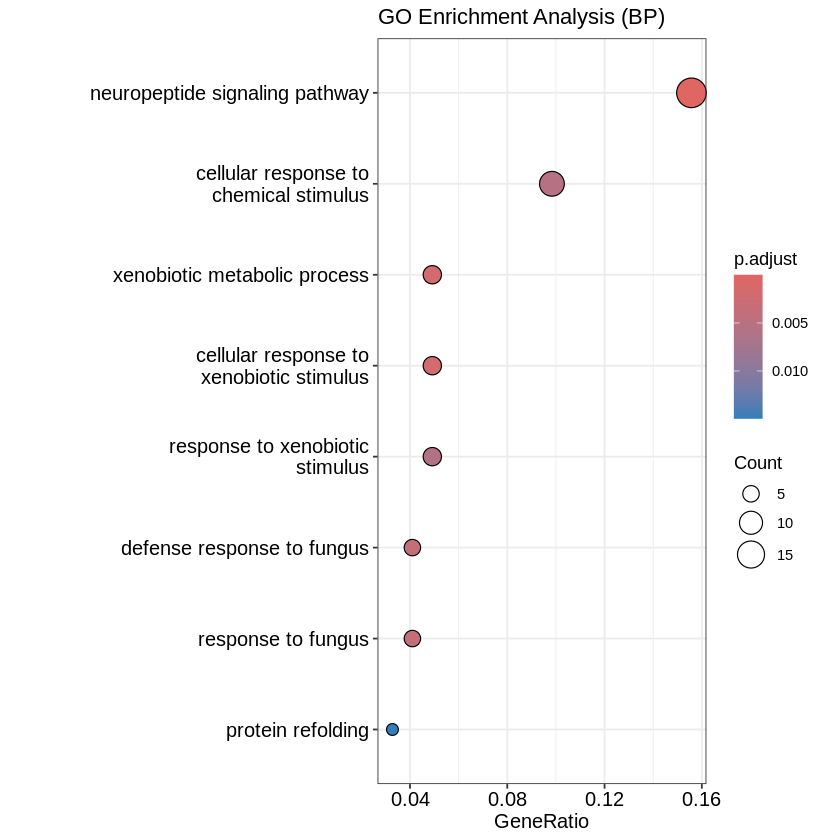

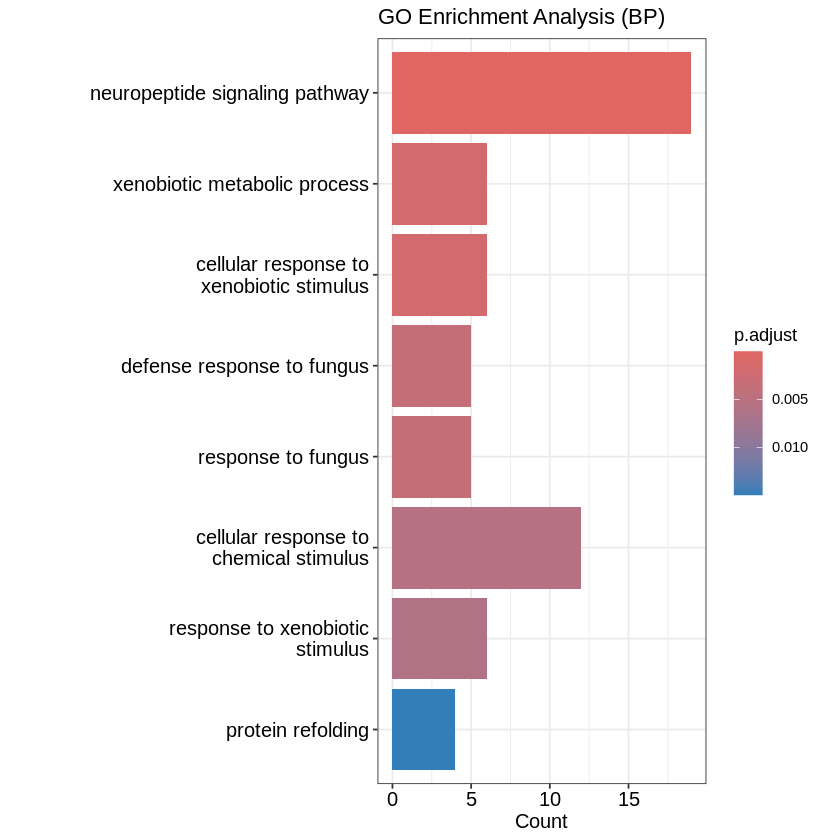

In [ ]:
# Realizamos el análisis de enriquecimiento GO para procesos biológicos (BP)
go_enrichment <- enrichGO(
  gene = genes_entrez_ids,
  OrgDb = org.Ce.eg.db,
  keyType = "ENTREZID",
  ont = "BP",  # Cambia a "MF" o "CC" si quieres analizar otras categorías
  pvalueCutoff = 0.05,
  qvalueCutoff = 0.2
)

# Mostramos los primeros resultados
print(head(go_enrichment))

# Visualizamos resultados

# Dotplot
dotplot(go_enrichment, showCategory = 20) +
  ggtitle("GO Enrichment Analysis (BP)")

# Barplot
barplot(go_enrichment, showCategory = 20) +
  ggtitle("GO Enrichment Analysis (BP)")



Módulos interesantes:

* Brown: Asociado al desarrollo temprano, con enriquecimiento en procesos de ciclo celular, replicación del ADN y mitosis.
* Darkgrey: Relacionado con el desarrollo neuronal y expresado principalmente durante el desarrollo medio.
* Darkmagenta: Implicado en la organogénesis, característico del desarrollo tardío.
* Yellowgreen: Involucrado en procesos *molting*, fundamentales para la transición entre etapas larvarias. Su expresión es más notable en larvas y adultos.
* Darkolivegreen: Asociado a la fase de Dauer
* Blue: Relacionado con la reproducción, con mayor expresión en la etapa adulta.





## Análisis temporal de expresión génica en un módulo de interés

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


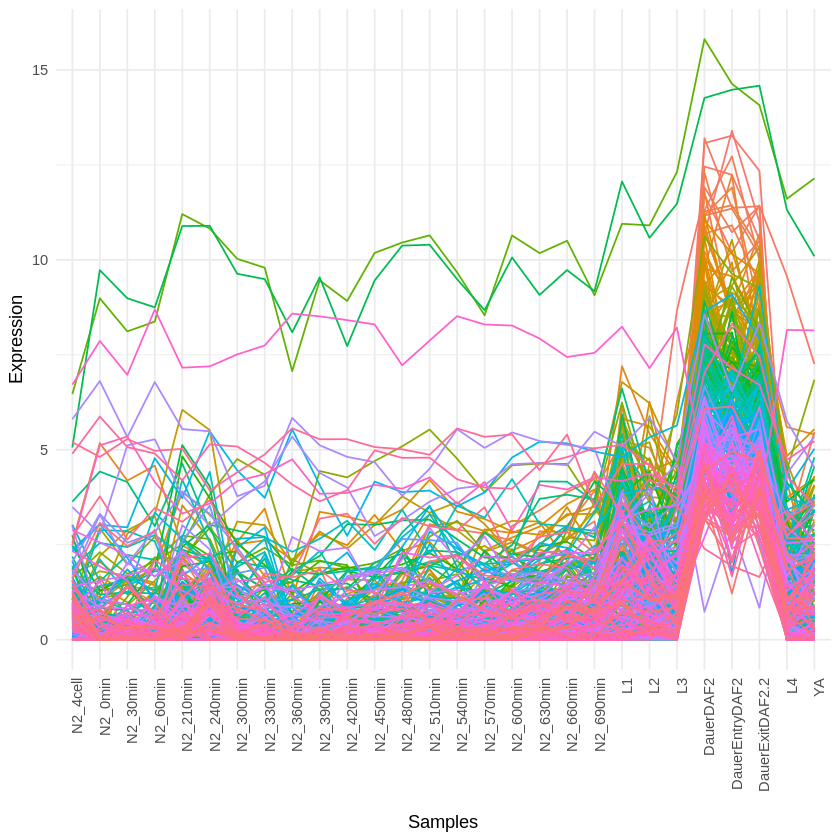

In [ ]:
# Genes que queremos visualizar
genes_interes <- significant_genes_by_color$darkolivegreen

# Filtramos el dataset con los genes de interés
subset_genes <- dataset[, genes_interes]

# Creamos un vector con los nombres de las muestras
muestras <- rownames(dataset)

# Convertimos a formato largo para ggplot2
library(reshape2)  # Para la transformación
data_long <- melt(subset_genes)
colnames(data_long) <- c("Muestra", "Gen", "Expresion")

# Creamos el spaghetti plot con ggplot2
library(ggplot2)
ggplot(data_long, aes(x = Muestra, y = Expresion, color = Gen, group = Gen)) +
  geom_line(size = 0.5) +         # Línea para cada gen
  theme_minimal() +
  labs(x = "Samples",
       y = "Expression") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1), legend.position = "none")


## Identificación y caracterización de hubgenes en un módulo de interés

Los hub genes son genes altamente conectados dentro de una red biológica, lo que refleja su papel central en la regulación de procesos celulares. En redes de co-expresión génica, estos genes muestran múltiples interacciones con otros, lo que sugiere su importancia funcional al actuar como reguladores clave de los procesos biológicos subyacentes a los módulos.

En esta sección identificaremos los 10 hubgenes de cada módulo. Luego, indagaremos sobre las anotaciones funcionales de cada gen.


In [ ]:
# Calcular conectividad intramódulo
IMconn <- intramodularConnectivity(adjacency(dataset, power = softPower), colors = dynamicColors)

In [ ]:
# Crear un listado de los top 10 hub genes por módulo
top10_hubs <- lapply(unique(dynamicColors), function(module) {
  # Filtrar genes por módulo específico
  module_genes <- IMconn[dynamicColors == module, ]

  # Ordenar los genes por conectividad (kWithin) en orden descendente
  top_genes <- module_genes[order(-module_genes$kWithin), ]

  # Seleccionar los 10 genes principales
  top_genes[1:min(10, nrow(top_genes)), ]
})


# Nombrar cada elemento de la lista según el módulo
names(top10_hubs) <- unique(dynamicColors)

In [ ]:
top10_hubs


,kTotal,kWithin,kOut,kDiff
,<dbl>,<dbl>,<dbl>,<dbl>
WBGene00010893,24.15031,15.01707,9.133245,5.883821
WBGene00019514,20.19957,14.77514,5.424430,9.350705
WBGene00018242,20.73934,13.55798,7.181359,6.376619
WBGene00044417,22.22454,13.36675,8.857789,4.508959
WBGene00001828,23.45891,12.69145,10.767468,1.923978
WBGene00021525,16.54294,12.54547,3.997462,8.548011
WBGene00019661,21.36990,12.46277,8.907124,3.555648
WBGene00001960,14.68483,12.25850,2.426330,9.832166
WBGene00008563,19.77165,11.43817,8.333472,3.104702


In [ ]:
# Extraemos todos los WormBase IDs únicos de los top10 hubs
all_genes <- unique(unlist(lapply(top10_hubs, function(df) rownames(df))))

# Conectamos a Ensembl para el dataset de C. elegans
ensembl <- useMart("ensembl", dataset = "celegans_gene_ensembl")

# Obtenemos la descripción y nombre del gen desde WormBase
gene_info <- getBM(
  attributes = c("wormbase_gene", "external_gene_name", "description"),
  filters = "wormbase_gene",
  values = all_genes,
  mart = ensembl
)

# Convertimos a data frame y renombrar las columnas
gene_info <- as.data.frame(gene_info)
colnames(gene_info) <- c("GeneID", "GeneName", "Description")

# Agregamos la descripción y el nombre del gen a cada data frame en top10_hubs sin perder el índice
top10_hubs <- lapply(top10_hubs, function(df) {
  df$GeneID <- rownames(df)  # Mueve el nombre del gen al DataFrame como columna
  df <- merge(df, gene_info, by = "GeneID", all.x = TRUE)  # Unimos con la descripción y nombre del gen
  df
})


In [ ]:
top10_hubs$brown

GeneID,kTotal,kWithin,kOut,kDiff,GeneName,Description
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
WBGene00009297,61.45200,47.41127,14.040726,33.37055,sdz-16,F-box associated domain-containing protein [Source:NCBI gene (formerly Entrezgene);Acc:180147]
WBGene00009537,58.12489,47.89073,10.234158,37.65657,ccch-2,C3H1-type domain-containing protein [Source:NCBI gene (formerly Entrezgene);Acc:178454]
WBGene00010689,58.35368,46.94655,11.407125,35.53943,K08H2.2,S ribonuclease [Source:NCBI gene (formerly Entrezgene);Acc:187175]
WBGene00012841,66.27162,48.30716,17.964465,30.34269,Y43F11A.1,Uncharacterized protein [Source:NCBI gene (formerly Entrezgene);Acc:174851]
WBGene00012844,64.31180,50.68271,13.629093,37.05362,Y43F11A.1,Uncharacterized protein [Source:NCBI gene (formerly Entrezgene);Acc:174851]
WBGene00013086,78.13744,51.45671,26.680727,24.77599,arrd-2,Arrestin C-terminal-like domain-containing protein [Source:NCBI gene (formerly Entrezgene);Acc:174491]
WBGene00016779,72.34240,48.11499,24.227409,23.88758,sdz-7,SKN-1 Dependent Zygotic transcript [Source:NCBI gene (formerly Entrezgene);Acc:260202]
WBGene00017405,79.77163,55.62537,24.146253,31.47912,bath-31,BTB domain-containing protein [Source:NCBI gene (formerly Entrezgene);Acc:173717]
WBGene00018247,58.70703,48.78071,9.926314,38.85440,F40G9.12,RING-type domain-containing protein [Source:NCBI gene (formerly Entrezgene);Acc:185559]


Visualicemos:

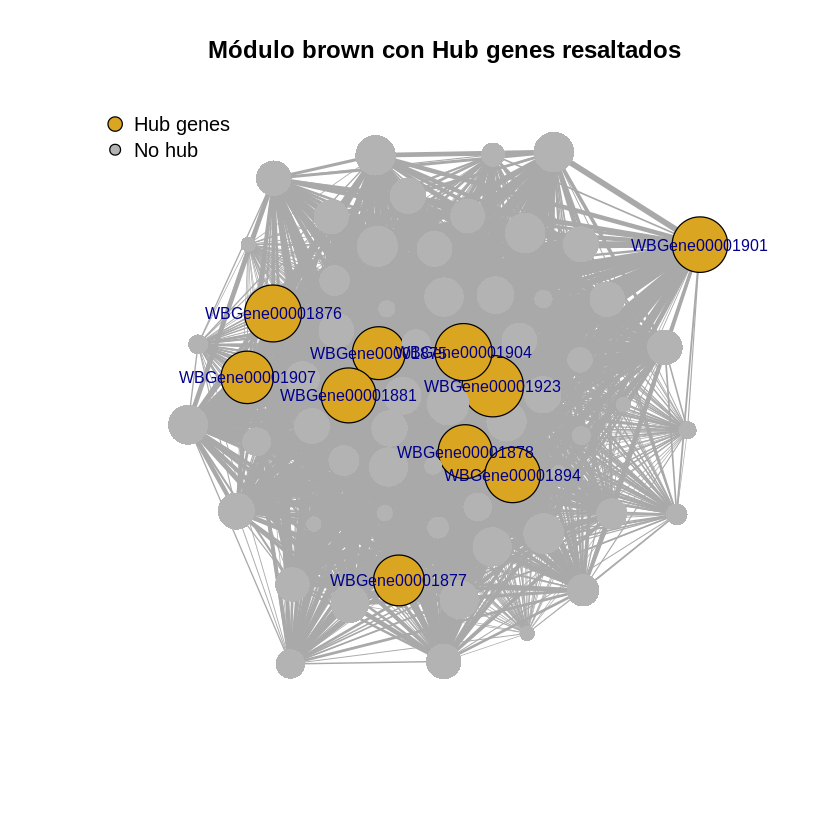

In [ ]:
library(igraph); library(scales)

## 1) Definiciones
genes_brown <- significant_genes_by_color$plum1                # genes del módulo brown
hubs_input  <- top10_hubs$plum1$GeneID            # vector de hub genes candidatos
hubs_brown  <- intersect(hubs_input, genes_brown) # por si alguno no pertenece al módulo

## 2) SubTOM del módulo y grafo completo (todas las aristas)
TOM_brown <- TOM[genes_brown, genes_brown]
g <- graph_from_adjacency_matrix(TOM_brown, mode = "undirected",
                                 weighted = TRUE, diag = FALSE)

## 3) Atributos de nodos
V(g)$is_hub <- V(g)$name %in% hubs_brown

# Tamaño por conectividad ponderada (strength) y resaltado para hubs
str_w <- strength(g, weights = E(g)$weight)
V(g)$size <- rescale(str_w, to = c(6, 20)) + ifelse(V(g)$is_hub, 4, 0)

# Colores y bordes
V(g)$color <- ifelse(V(g)$is_hub, "goldenrod", "grey70")
V(g)$frame.color <- ifelse(V(g)$is_hub, "black", NA)

# Etiquetas: solo hubs (cambia a V(g)$name si quieres todos)
V(g)$label <- ifelse(V(g)$is_hub, V(g)$name, NA)
V(g)$label.cex <- ifelse(V(g)$is_hub, 0.8, NA)

## 4) Atributos de aristas
# Grosor según peso TOM (todas las aristas visibles)
E(g)$width <- rescale(E(g)$weight, to = c(0.5, 6))

## 5) Layout y plot
set.seed(42)

layout_drl <- layout_with_drl(g, options = list(simmer.attraction = 0))
plot(g,
     layout = layout_drl,
     vertex.label.family = "sans",
     main = "Módulo brown con Hub genes resaltados")


## 6) (Opcional) Leyenda simple en base R
legend("topleft",
       legend = c("Hub genes", "No hub"),
       pch = 21,
       pt.bg = c("goldenrod", "grey70"),
       pt.cex = c(1.6, 1.2),
       bty = "n")

En caso de encontrar hubgenes sin una función conocida o clara, es posible intentar inferir su anotación utilizando diferentes estrategias:
* Una opción es realizar una búsqueda de homología estructural mediante la predicción de sus estructuras proteicas utlizando AlphaFold, y luego la búsqueda de homología con FoldSeek (https://search.foldseek.com/search), que permite identificar similitudes con otras proteínas conocidas.
* Otra opción puede ser aplicar metodologías más abarcativas, como exp2GO, que asigna funciones basadas en datos de expresión y anotaciones de ontología génica (https://ieeexplore.ieee.org/document/9756915).

# Motivos compartidos en 3'UTRs

Un mecanismo frecuente de regulación de la expresión génica es el control traduccional de ARNm. Este control permite cambios rápidos en la expresión génica y es especialmente relevante en situaciones donde la transcripción está reducida o detenida, como durante el estrés celular o el desarrollo temprano.

Las proteínas de unión a ARN (RBPs) regulan la vida del ARNm desde su producción hasta su degradación. Algunas RBPs actúan sobre elementos específicos en el ARNm, generalmente en las regiones no traducidas (UTRs) 5' y 3'. Aunque las RBPs podrían activar o reprimir la traducción, la mayoría de los casos conocidos muestran que estas proteínas reprimen la traducción al unirse al 3'UTR, una región clave para la estabilidad, localización intracelular y regulación del ARNm (https://academic.oup.com/bfg/article/12/1/58/186854). A su vez, múltiples ARNm pueden ser co-regulados por una o más RBPs, dando lugar a un modelo en el que los ARNm que codifican proteínas funcionalmente relacionadas son regulados de manera coordinada a través de un mecanismo impulsado por RBPs, a lo que se llama regulones post-transcripcionales (https://www.nature.com/articles/nrg2111).

En este apartado, intentaremos identificar motivos sobrerrepresentados en las regiones 3'UTRs de los genes pertenecientes al módulo darkolivegreen y RBPs que se unen a estos, como un posible mecanismo de regulación que determina la expresión conjunta de estos genes.

In [ ]:
length(significant_genes_by_color$darkolivegreen)

[1] 301

In [ ]:
# Vamos a volver a usar Ensembl para obtener las secuencias 3'utr
utr_sequences <- getBM(
  attributes = c("wormbase_gene", "3utr"),
  filters = "wormbase_gene",
  values = significant_genes_by_color$darkolivegreen,
  mart = ensembl
)
head(utr_sequences)
dim(utr_sequences)

,wormbase_gene,3utr
,<chr>,<chr>
1,WBGene00004443,ATTGTTGTTAATTCGGATAAACTTTGTTACCTTT
2,WBGene00015578,TGTTTTTTTTTTTTTTTTAATTTAAAATTTTAAATTTTGCCATCTATTTTTAATCTAATAAACAATTTCATTTT
3,WBGene00015406,Sequence unavailable
4,WBGene00044687,TTGAATACTCTTCTTGTATCACGTTATTCTACTGGTTCACACTTTTTCCCACAGTAATAAAAGATTACCTGTCA
5,WBGene00194890,CATTCATTTTGTATTATCTGTTTTCATAATACAACAAGAACTGAATAGGAATTTTTCAAAAATAAAA
6,WBGene00015592,Sequence unavailable


[1] 381   2

In [ ]:
# Como hay valores que no corresponden a secuencias de nt en la columna 3utr, vamos a eliminar esos genes
utr_sequences <- utr_sequences[grepl("^[ATCGatcg]+$", utr_sequences$`3utr`), ]
head(utr_sequences)
dim(utr_sequences)

,wormbase_gene,3utr
,<chr>,<chr>
1,WBGene00004443,ATTGTTGTTAATTCGGATAAACTTTGTTACCTTT
2,WBGene00015578,TGTTTTTTTTTTTTTTTTAATTTAAAATTTTAAATTTTGCCATCTATTTTTAATCTAATAAACAATTTCATTTT
4,WBGene00044687,TTGAATACTCTTCTTGTATCACGTTATTCTACTGGTTCACACTTTTTCCCACAGTAATAAAAGATTACCTGTCA
5,WBGene00194890,CATTCATTTTGTATTATCTGTTTTCATAATACAACAAGAACTGAATAGGAATTTTTCAAAAATAAAA
7,WBGene00003739,ACTCCAGCGAACATCAAGCTACTTTCATCCCAATTGCTTCTTCTTAGTCCCAAATATGATAACACTCTTTCCATAAAATCGTTTTTGTGCAATAAATTGATTGTATGGGAAATACATCGAAGATCTTTTAGCTAATAAAATGTTACAAAAATTGCCGTTC
8,WBGene00000133,AATTAATTTCAAATGTTCAAATATACTTTATTTTTCTCCAAATTTTCTCGTTTTCTTCTTCATTTTCTCATTTCCTCATCACTTCAATGAAGTTTTTATGCTC


[1] 297   2

In [ ]:
# Ahora vemos que muchos UTRs tienen pocos caracteres, por lo que vamos a eliminar
# Todos los genes que tengan menos de 4 caracteres
utr_sequences <- utr_sequences[nchar(utr_sequences$`3utr`) >= 4, ]
dim(utr_sequences)

[1] 297   2

In [ ]:
# Filtramos los duplicados de wormbase_gene y nos quedamos con la secuencia 3utr más larga en cada uno
utr_sequences <- utr_sequences %>%
  group_by(wormbase_gene) %>%                     # Agrupa por wormbase_gene
  slice_max(nchar(`3utr`), with_ties = FALSE) %>% # Selecciona la secuencia 3utr más larga en cada grupo
  ungroup()                                       # Desagrupa para devolver un data frame sin agrupación

# Verificamos el resultado
dim(utr_sequences)

[1] 250   2

Ahora vamos a usar el paquete `Biostrings` para pasar los UTRs a un archivo fasta



In [ ]:
# Convertimos las secuencias 3'UTR a un objeto DNAStringSet
utr_sequences_set <- DNAStringSet(utr_sequences$`3utr`, use.names = TRUE)
names(utr_sequences_set) <- utr_sequences$wormbase_gene

head(utr_sequences_set)


DNAStringSet object of length 6:
    width seq                                               names               
[1]   103 AATTAATTTCAAATGTTCAAATA...ACTTCAATGAAGTTTTTATGCTC WBGene00000133
[2]   126 TCAACGCTTGTTATTTATCTCTG...CATAATAATAAAAATTTAATTAC WBGene00000171
[3]   163 GCAACCCGCATCAATCGATAATT...ATAAATAAACTTGTCTATAATTT WBGene00000560
[4]    89 TCAGCTGCTCAAGGAACCTCTTT...TAAATAAATTATATTTCATCCAA WBGene00000932
[5]    58 ATTTTTGTTCATATTTTCCTTTT...GGAATAAATACAGACTACCTTAA WBGene00000978
[6]    61 ATTTTGAATCGCGTTGAATTTTT...AGATAATAAACATATTGTAGTAT WBGene00001763

In [ ]:
# Creamos un archivo FASTA
writeXStringSet(utr_sequences_set, filepath = "darkolivegreen_3utr_sequences.fasta")

# El archivo creado lo vamos a ver en las carpetitas de al lado <-

In [ ]:
# Obtenemos los nombres de los genes que NO pertenecen al módulo darkolivegreen
genes_otros_modulos <- df_moduleColors %>%
  filter(ModuleColor != "darkolivegreen") %>%
  pull(Gene)

# Obtenemos las secuencias 3'UTR para estos genes
utr_sequences_otros <- getBM(
  attributes = c("wormbase_gene", "3utr"),
  filters = "wormbase_gene",
  values = genes_otros_modulos,
  mart = ensembl
)

# Limpiamos las secuencias como se hizo previamente
utr_sequences_otros <- utr_sequences_otros[grepl("^[ATCGatcg]+$", utr_sequences_otros$`3utr`), ]
utr_sequences_otros <- utr_sequences_otros[nchar(utr_sequences_otros$`3utr`) >= 4, ]

# Filtramos duplicados y nos quedamos con la secuencia más larga
utr_sequences_otros <- utr_sequences_otros %>%
  group_by(wormbase_gene) %>%
  slice_max(nchar(`3utr`), with_ties = FALSE) %>%
  ungroup()

# Convertimos a DNAStringSet y nombramos las secuencias
utr_sequences_otros_set <- DNAStringSet(utr_sequences_otros$`3utr`, use.names = TRUE)
names(utr_sequences_otros_set) <- utr_sequences_otros$wormbase_gene

# Escribimos el archivo FASTA
writeXStringSet(utr_sequences_otros_set, filepath = "non_darkolivegreen_3utr_sequences.fasta")

Para seguir el análisis de UTRs, vamos a seguir en la página https://meme-suite.org/meme/tools/xstreme. Este software nos permitirá identificar motivos sobrerrepresentados en los 3'UTRs de los genes pertenecientes al módulo de interés y posibles RBPs reportadas.